### Анализ пользовательского поведения в мобильном приложении

### Описание сгенерированных таблиц проекта

Датасет представляет собой симуляцию пользовательского поведения в Telegram, включая активность, использование функций и оформление подписки Telegram Premium. Ниже приведены описания всех таблиц, полученных в ходе генерации данных.


1. `telegram_user_data.csv`

Содержит информацию о 10000 пользователях платформы.

•	user_id — уникальный идентификатор пользователя \
•	location — город пользователя (6 основных городов России) \
•	activity_category — уровень активности (active, medium, rare) \
•	is_premium — флаг, показывающий наличие подписки на 30.06.2023 (1 — есть подписка, 0 — нет) \
•	dominant_platform — преобладающая платформа пользователя (iOS, Android, Desktop)
    
2. `telegram_logs.csv`

Логи всех пользовательских действий (включая действия до и после подписки)

•	user_id \
•	session_id — уникальный идентификатор сессии \
•	timestamp — время события \
•	event_type — тип события (например: view_main_screen, send_message, buy_premium, и т.д.)

Особенность:
Пользователи с подпиской проявляют более высокую активность после подписки (увеличенный множитель event_multiplier = 1.4).


3. `telegram_premium_purchases.csv`

Информация о покупках премиум-подпискок в январе 2023.

•	user_id \
•	timestamp — дата покупки \
•	subscription_type — тип подписки (3_months, 6_months, 12_months) \
•	purchase_source — откуда оформлена покупка (in-app или website) \
•	purchase_price — цена в зависимости от типа подписки
    

4. `telegram_premium_historical_2022.csv`

История премиум-подписок пользователей за 2022 год (для расчёта флага is_premium на 30-06-2023).

•	user_id \
•	timestamp — дата покупки \
•	subscription_type — тип подписки \
•	purchase_source \
•	purchase_price \
•	subscription_end — автоматически рассчитанная дата окончания подписки
    


In [675]:
plt.style.use('ggplot')
from pandas.tseries.offsets import DateOffset
from scipy import stats

### Загрузка данных:

In [322]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

# Загрузка таблиц
user_data_df = pd.read_csv("telegram_user_data.csv")
logs_df = pd.read_csv("telegram_logs.csv", parse_dates=['timestamp'])
premium_purchases_df = pd.read_csv("telegram_premium_purchases.csv", parse_dates=['timestamp'])
premium_purchases_hist_df = pd.read_csv("telegram_premium_historical_2022.csv", parse_dates=['timestamp'])
stars_purchases_df = pd.read_csv("telegram_stars_purchases.csv", parse_dates=['timestamp'])

### Exploratory Data Analysis (EDA):

In [323]:
print("User data:", user_data_df.shape)
print("Logs:", logs_df.shape)
print("Premium purchases:", premium_purchases_df.shape)
print("Historical premium purchases:", premium_purchases_hist_df.shape)
print("Stars purchases:", stars_purchases_df.shape)

user_data_df.head()

User data: (10000, 6)
Logs: (21526907, 5)
Premium purchases: (798, 5)
Historical premium purchases: (1175, 6)
Stars purchases: (373124, 5)


,user_id,location,activity_category,churn_date,is_premium,dominant_platform
0,1,Ekaterinburg,medium,NaN,0,iOS
1,2,Kazan,medium,NaN,0,Android
2,3,Novosibirsk,medium,NaN,0,iOS
3,4,Kazan,medium,NaN,0,iOS
4,5,Kazan,active,NaN,0,Android


In [326]:
print(logs_df.duplicated().sum())
print(user_data_df.duplicated().sum())
print(premium_purchases_df.duplicated().sum())
print(premium_purchases_hist_df.duplicated().sum())
print(stars_purchases_df.duplicated().sum())

0
0
0
0
0


In [327]:
# stars_purchases_df = stars_purchases_df.drop_duplicates()

In [402]:
# logs_df = logs_df.drop_duplicates()

In [79]:
# logs_df

In [328]:
dfs = [
    ("logs_df", logs_df),
    ("user_data_df", user_data_df),
    ("premium_purchases_df", premium_purchases_df),
    ("premium_purchases_hist_df", premium_purchases_hist_df)
]

for name, df in dfs:
    if name == 'logs_df':
        check = ["user_id", "timestamp", "event_type"]
    elif name == 'user_data_df':
        check = ["user_id"]
    elif name == 'premium_purchases_df' or name == 'premium_purchases_hist_df':
        check = ["user_id", "timestamp"]

        
    if all(col in df.columns for col in check):
        # Посчитаем дубли по комбинации ключевых полей
        duplicate_events = df[df.duplicated(subset=check, \
                                            keep=False)]

        # Посмотрим сколько их
        print(f"{name}: найдено {len(duplicate_events)} дублирующихся событий.")
    else:
        print(f"{name}: нет нужных колонок для проверки.")

logs_df: найдено 1610 дублирующихся событий.
user_data_df: найдено 0 дублирующихся событий.
premium_purchases_df: найдено 0 дублирующихся событий.
premium_purchases_hist_df: найдено 0 дублирующихся событий.


In [329]:
logs_df[logs_df.duplicated(subset=["user_id", "timestamp", "event_type"], \
                          keep = False)].head(6)

,user_id,session_id,timestamp,event_type,platform
47350,25,10b6a662-2ac1-45ca-8e5d-8f1296b31f4a,2023-06-02 19:45:07,extra_reactions,iOS
47356,25,10b6a662-2ac1-45ca-8e5d-8f1296b31f4a,2023-06-02 19:45:24,telegram_app_icon,iOS
47359,25,10b6a662-2ac1-45ca-8e5d-8f1296b31f4a,2023-06-02 19:45:35,extra_reactions,iOS
47365,25,10b6a662-2ac1-45ca-8e5d-8f1296b31f4a,2023-06-02 19:45:47,extra_reactions,iOS
47372,25,10b6a662-2ac1-45ca-8e5d-8f1296b31f4a,2023-06-02 19:46:06,telegram_app_icon,iOS
47395,25,f2ce7eeb-4c56-4b8f-8bb4-32b3d2e76deb,2023-06-02 19:45:07,extra_reactions,iOS


Удалю дубли, оставив первую из повторяющихся строк

In [330]:
logs_df.drop_duplicates(subset=["user_id", "timestamp", "event_type"], \
                        keep='first', \
                        inplace=True)

In [334]:
# logs_df[logs_df.duplicated(subset=["user_id", "timestamp"], \
#                           keep = False)].count()

In [335]:
# logs_df.drop_duplicates(subset=["user_id", "timestamp"], \
#                         keep='first', \
#                         inplace=True)

#### Проверка категориальных данных

In [336]:
print(f"event_type in logs_df: {logs_df['event_type'].unique()}", end = '\n\n')
print(f"platforms in logs_df: {logs_df['platform'].unique()}", end = '\n\n')

print(f"location in user_data_df: {user_data_df['location'].unique()}", end = '\n\n')
print(f"activity_category in user_data_df: {user_data_df['activity_category'].unique()}", end = '\n\n')
print(f"dominant_platform in user_data_df: {user_data_df['dominant_platform'].unique()}", end = '\n\n')

print(f"subscription_type in premium_purchases_df: {premium_purchases_df['subscription_type'].unique()}", end = '\n\n')
print(f"purchase_source in premium_purchases_df: {premium_purchases_df['purchase_source'].unique()}", end = '\n\n')
print(f"purchase_price in premium_purchases_df: {premium_purchases_df['purchase_price'].unique()}", end = '\n\n')

print(f"subscription_type in premium_purchases_hist_df: {premium_purchases_hist_df['subscription_type'].unique()}", end = '\n\n')
print(f"purchase_source in premium_purchases_hist_df: {premium_purchases_hist_df['purchase_source'].unique()}", end = '\n\n')
print(f"purchase_price in premium_purchases_hist_df: {premium_purchases_hist_df['purchase_price'].unique()}", end = '\n\n')

print(f"stars_type in stars_purchases_df: {stars_purchases_df['stars_type'].unique()}", end = '\n\n')
print(f"purchase_source in stars_purchases_df: {stars_purchases_df['purchase_source'].unique()}", end = '\n\n')
print(f"purchase_price in stars_purchases_df: {stars_purchases_df['purchase_price'].unique()}", end = '\n\n')

event_type in logs_df: ['buy_stars' 'view_main_screen' 'send_message' 'react_to_message'
 'send_voice_message' 'open_chat' 'send_sticker' 'video_call'
 'open_dialog' 'send_video_message' 'voice_call' 'buy_premium'
 'use_custom_emoji' 'post_story' 'voice_to_text' 'extra_reactions'
 'telegram_app_icon' 'animated_profile_picture' 'extra_cloud_storage'
 'emoji_status_profile']

platforms in logs_df: ['iOS' 'Desktop' 'Android']

location in user_data_df: ['Ekaterinburg' 'Kazan' 'Novosibirsk' 'Saint Petersburg' 'Nizhny Novgorod'
 'Moscow']

activity_category in user_data_df: ['medium' 'active' 'rare']

dominant_platform in user_data_df: ['iOS' 'Android']

subscription_type in premium_purchases_df: ['12_months' '3_months' '6_months']

purchase_source in premium_purchases_df: ['in-app' 'website']

purchase_price in premium_purchases_df: [3190  899 1690]

subscription_type in premium_purchases_hist_df: ['12_months' '6_months' '3_months']

purchase_source in premium_purchases_hist_df: ['in-app' 

<Axes: >

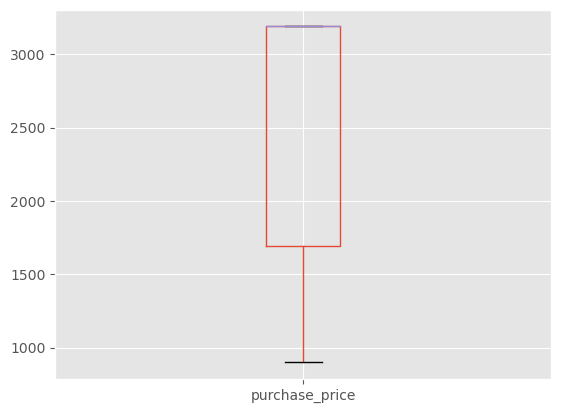

In [337]:
premium_purchases_df.boxplot(column='purchase_price')

<Axes: >

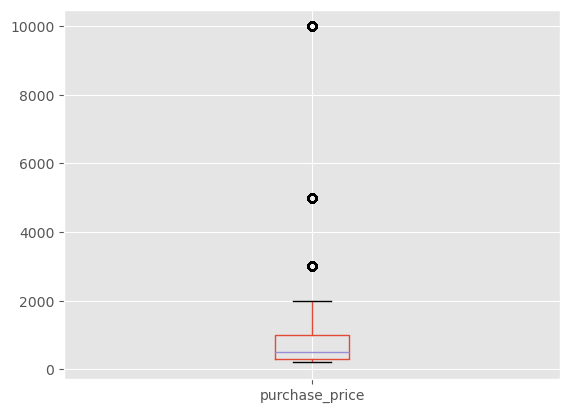

In [338]:
stars_purchases_df.boxplot(column='purchase_price')

#### Проверка временных данных

In [440]:
# Проверка диапазона дат
min_date = logs_df['timestamp'].min()
max_date = logs_df['timestamp'].max()
print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

min_date = premium_purchases_df['timestamp'].min()
max_date = premium_purchases_df['timestamp'].max()
print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

min_date = premium_purchases_hist_df['timestamp'].min()
max_date = premium_purchases_hist_df['timestamp'].max()
print(f"Минимальная дата: {min_date}, Максимальная дата: {max_date}")

Минимальная дата: 2023-01-01 05:57:23, Максимальная дата: 2023-06-30 23:59:59
Минимальная дата: 2023-01-01 05:57:23, Максимальная дата: 2023-06-30 23:53:44
Минимальная дата: 2022-01-01 12:27:47, Максимальная дата: 2022-12-31 10:36:30


In [344]:
cutoff_date = pd.Timestamp("2023-07-01")
logs_df = logs_df[logs_df['timestamp'] < cutoff_date]

In [291]:
# Проверка, есть ли user_id в обеих таблицах (пользователи и покупки)
if 'user_id' not in user_data_df.columns or 'user_id' not in premium_purchases_df.columns:
    print("Ошибка: Нет столбца 'user_id' в одной из таблиц")
else:
    # Есть ли user_id в обеих таблицах
    users_in_both = user_data_df[user_data_df['user_id'].isin(premium_purchases_df['user_id'])]
    purchases_in_both = premium_purchases_df[premium_purchases_df['user_id'].isin(user_data_df['user_id'])]
    print(f"Количество пользователей в обеих таблицах: {len(users_in_both)}")
    print(f"Количество покупок с действующими пользователями: {len(purchases_in_both)}")

    # Есть ли покупки без пользователей или наоборот
    purchases_without_user = premium_purchases_df[~premium_purchases_df['user_id'].isin(user_data_df['user_id'])]
    users_without_purchase = user_data_df[~user_data_df['user_id'].isin(premium_purchases_df['user_id'])]
    
    if not purchases_without_user.empty:
        print(f"Найдены покупки без пользователей: {len(purchases_without_user)} строк")
    
    if not users_without_purchase.empty:
        print(f"Найдены пользователи без покупок: {len(users_without_purchase)} строк")

Количество пользователей в обеих таблицах: 798
Количество покупок с действующими пользователями: 798
Найдены пользователи без покупок: 9202 строк


##### Распределение пользователей по платформам

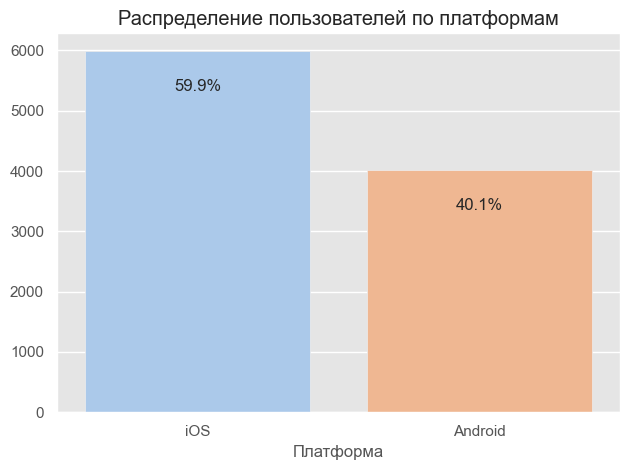

In [693]:
ax = sns.countplot(data=user_data_df, \
                   x="dominant_platform", \
                   order=user_data_df["dominant_platform"].value_counts().index, 
                   palette='pastel')

total = len(user_data_df)

# Добавляем проценты над столбцами
for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), \
                ha='center', va='top', fontsize=12, \
                xytext=(0, -20),
                textcoords='offset points')

plt.title("Распределение пользователей по платформам")
plt.xlabel("Платформа")
# plt.ylabel("Количество пользователей")
plt.ylabel("")
plt.tight_layout()
plt.show()

##### Распределение пользователей по активности

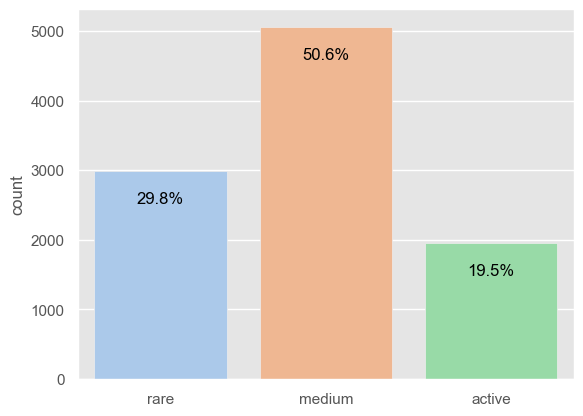

In [694]:
ax = sns.countplot(data=user_data_df, x="activity_category", \
                   order=["rare", "medium", "active"], \
                   palette='pastel')

counts = user_data_df["activity_category"].value_counts()
total = len(user_data_df)

# Добавляем проценты на график
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, -20), textcoords='offset points')
plt.xlabel("")
plt.show()

##### Какой источник для покупки премиум подписки использовался чаще?

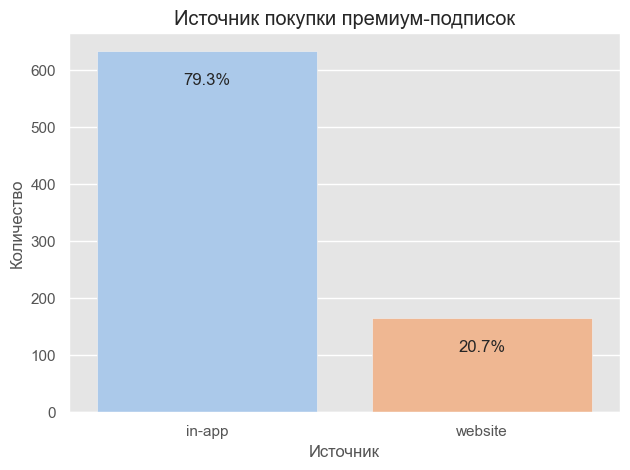

In [695]:
ax = sns.countplot(data=premium_purchases_df, x="purchase_source", palette='pastel')

total = len(premium_purchases_df)

for p in ax.patches:
    count = p.get_height()
    percentage = f'{100 * count / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y + total * 0.01), ha='center', va='bottom', \
                xytext=(0, -30), textcoords='offset points', fontsize=12)

plt.title("Источник покупки премиум-подписок")
plt.xlabel("Источник")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

##### Сколько раз пользователи покупали премиум? (на человека)

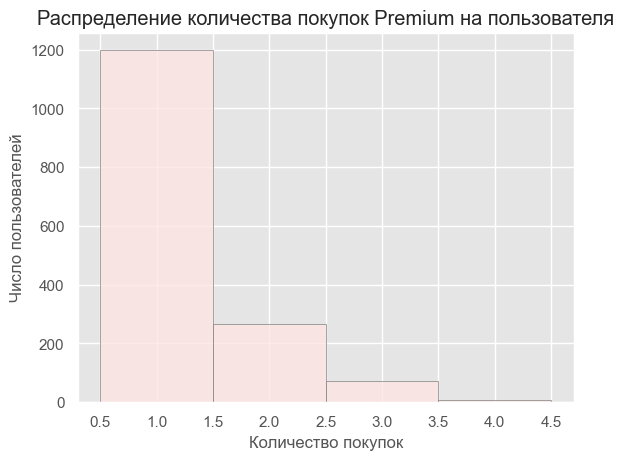

In [696]:
all_purchases_df = pd.concat([premium_purchases_df, premium_purchases_hist_df])

repeats = all_purchases_df.groupby('user_id').size().reset_index(name='purchase_count')

sns.histplot(repeats['purchase_count'], bins=5, discrete=True, color='mistyrose', \
            edgecolor='gray',
            linewidth=0.5 )
plt.title("Распределение количества покупок Premium на пользователя")
plt.xlabel("Количество покупок")
plt.ylabel("Число пользователей")
plt.show()

##### Топ-10 используемых премиум-функций

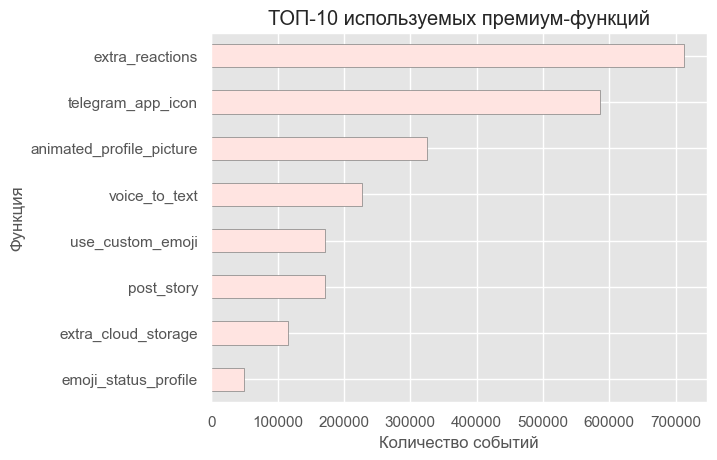

In [697]:
premium_event_types = [
    "use_custom_emoji", "post_story", "voice_to_text", "extra_cloud_storage",
    "emoji_status_profile", "custom_profile", "telegram_app_icon",
    "animated_profile_picture", "extra_reactions"
]
top_premium_features = logs_df[logs_df['event_type'].isin(premium_event_types)] \
                               .event_type.value_counts().head(10)

top_premium_features.plot(kind='barh', color='mistyrose', edgecolor='grey', linewidth=0.5)
plt.title("ТОП-10 используемых премиум-функций")
plt.xlabel("Количество событий")
plt.ylabel("Функция")
plt.gca().invert_yaxis()
plt.show()

## Аналитические задачи:

### 1. Какие метрики выбрать для отслеживания динамики покупок телеграм премиума?

Основные метрики:

• Количество новых подписчиков (New Premium Users) – сколько человек купило подписку впервые \
• Retention Rate (через 1/3/6 месяцев) – сколько пользователей продолжают подписку \
• Churn Rate – процент оттока подписчиков \
• Средний чек (ARPU – Average Revenue Per User) \
• Доля пользователей, купивших подписку, среди всех активных пользователей (Conversion Rate to Premium) 
<!-- • Выручка по платформам (App Store, Google Play, веб-оплата) -->

Дополнительно:

• Cohort Analysis – как ведут себя подписчики, купившие Premium в разные месяцы \
• CAC (Customer Acquisition Cost) – сколько стоит привлечение Premium-пользователя


##### Количество новых подписчиков за последние полгода

In [698]:
# Считаем новых премиум пользователей
new_premium_users = premium_purchases_df[premium_purchases_df['timestamp'] == premium_purchases_df.groupby('user_id')['timestamp'].transform('min')]

# Количество новых подписчиков
new_premium_count = new_premium_users['user_id'].nunique()

premium_purchases_hist_ids = premium_purchases_hist_df['user_id'].unique()
new_purchases = premium_purchases_df[~premium_purchases_df['user_id'] \
                                     .isin(premium_purchases_hist_ids)].user_id.count()

print(f'Общее количество пользователей, купивших подписку (с 2023-01-01 по 2023-06-30): {new_premium_count}')
print(f'Количество новых пользователей, купивших подписку впервые: {new_purchases}')

Общее количество пользователей, купивших подписку (с 2023-01-01 по 2023-06-30): 798
Количество новых пользователей, купивших подписку впервые: 743


##### Retention Rate (через 1, 2, 3, 4, 5, 6 месяцев)

In [699]:
# Сколько пользователей продолжают использовать подписку через 1, 2, 3, 4, 5, 6 месяцев

# Добавим столбец с датой окончания подписки
premium_purchases_df['subscription_end'] = premium_purchases_df['timestamp'] \
                + pd.to_timedelta(premium_purchases_df['subscription_type'] \
                .map({'1_months': '30D',
                      '2_months': '60D', 
                      '3_months': '90D', 
                      '4_months': '120D', 
                      '5_months': '150D', 
                      '6_months': '180D'
}))

# Определим retention через 1, 2, 3, 4, 5, 6 месяцев
def calculate_retention(months):
    retention_date = pd.to_datetime("2023-06-30") - pd.DateOffset(months=months)
    retained_users = premium_purchases_df[
        (premium_purchases_df['timestamp'] <= retention_date) &
        (premium_purchases_df['subscription_end'] > retention_date)
    ]
    return retained_users['user_id'].nunique()

# Retention rate через 1, 2, 3, 4, 5, 6 месяцев
retention_1_month = calculate_retention(1)
retention_2_months = calculate_retention(2)
retention_3_months = calculate_retention(3)
retention_4_months = calculate_retention(4)
retention_5_months = calculate_retention(5)
retention_6_months = calculate_retention(6)

print(f"Retention через 1 месяц: {retention_1_month}")
print(f"Retention через 2 месяца: {retention_2_months}")
print(f"Retention через 3 месяца: {retention_3_months}")
print(f"Retention через 4 месяца: {retention_4_months}")
print(f"Retention через 5 месяцев: {retention_5_months}")
print(f"Retention через 6 месяцев: {retention_6_months}")

Retention через 1 месяц: 211
Retention через 2 месяца: 192
Retention через 3 месяца: 155
Retention через 4 месяца: 103
Retention через 5 месяцев: 56
Retention через 6 месяцев: 0


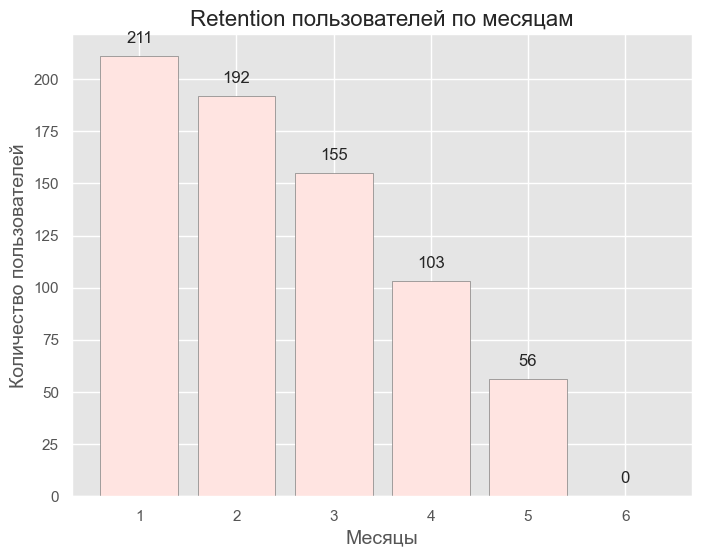

In [700]:
# Список месяцев и значений retention
months = [1, 2, 3, 4, 5, 6]
retention_values = [
    retention_1_month, 
    retention_2_months, 
    retention_3_months, 
    retention_4_months, 
    retention_5_months, 
    retention_6_months
]

# Строим столбчатую диаграмму
plt.figure(figsize=(8, 6))
plt.bar(months, retention_values, color='mistyrose', edgecolor='grey')

# Добавляем подписи и заголовок
plt.xlabel('Месяцы', fontsize=14)
plt.ylabel('Количество пользователей', fontsize=14)
plt.title('Retention пользователей по месяцам', fontsize=16)

# Добавляем значение на вершине столбцов для каждого месяца
for i, value in enumerate(retention_values):
    plt.text(months[i], value + 5, str(value), ha='center', va='bottom', fontsize=12)

# Показываем график
plt.xticks(months)
plt.show()

In [701]:
# # Строим линейный график
# plt.figure(figsize=(8, 6))
# plt.plot(months, retention_values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)

# # Добавляем подписи и заголовок
# plt.xlabel('Месяцы', fontsize=14)
# plt.ylabel('Количество пользователей', fontsize=14)
# plt.title('Retention пользователей по месяцам', fontsize=16)

# # Показываем график
# plt.xticks(months)
# plt.grid(True)
# plt.show()

##### Churn Rate

In [702]:
# Churn rate на 2023-06-30
def calculate_churn_rate():
    churned_users = premium_purchases_df[
        premium_purchases_df['subscription_end'] < pd.to_datetime("2023-06-30")
    ]
    churn_rate = len(churned_users) / len(new_premium_users) * 100
    return churn_rate

churn_rate = calculate_churn_rate()
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 6.77%


##### Средний чек (ARPPU – Average Revenue Per User)

In [530]:
# Рассчитаем выручку за каждый месяц
premium_purchases_df['revenue'] = premium_purchases_df['purchase_price']

# ARPU (средний доход на пользователя)
total_revenue = premium_purchases_df['revenue'].sum()
total_users = len(premium_purchases_df['user_id'].unique())
arpu = total_revenue / total_users
print(f"Средний чек (ARPPU): {arpu:.2f} руб.")

Средний чек (ARPPU): 2491.90 руб.


##### Средний чек (ARPU – Average Revenue Per User)

In [531]:
# Рассчитаем выручку за каждый месяц
premium_purchases_df['revenue'] = premium_purchases_df['purchase_price']

# ARPU (средний доход на пользователя)
total_revenue = premium_purchases_df['revenue'].sum()
total_users = len(logs_df['user_id'].unique())
arpu = total_revenue / total_users
print(f"Средний чек (ARPU): {arpu:.2f} руб.")

Средний чек (ARPU): 199.53 руб.


#####  Доля пользователей, купивших подписку, среди всех активных пользователей (Conversion Rate to Premium)

In [532]:
# Активные пользователи
active_users = user_data_df[user_data_df['activity_category'] == 'active']

# Conversion rate to premium
conversion_rate = len(new_premium_users) / len(active_users) * 100
print(f"Конверсия в покупку премиума у АКТИВНЫХ пользователей: {conversion_rate:.2f}%")

Конверсия в покупку премиума у АКТИВНЫХ пользователей: 40.84%


#####  Доля пользователей, купивших подписку, среди всех пользователей (Conversion Rate to Premium)

In [533]:
# Объединяем ID пользователей, купивших премиум (в любом году)
all_premium_ids = pd.concat([premium_purchases_df['user_id'], \
                             premium_purchases_hist_df['user_id']]).unique()

january_premium_ids = premium_purchases_df['user_id'].unique()

# Общая доля таких пользователей
total_users = user_data_df['user_id'].nunique()
premium_users = len(all_premium_ids)
premium_ratio = premium_users / total_users

premium_users_6 = len(january_premium_ids)
premium_ratio_6 = premium_users_6 / total_users

print(f"Премиум покупали ВСЕГО: {premium_users} из {total_users} пользователей")
print(f"Конверсия: {premium_ratio:.2%}")
print()
print(f"За полгода премиум купили: {premium_users_6} из {total_users} пользователей")
print(f"Конверсия: {premium_ratio_6:.2%}")

Премиум покупали ВСЕГО: 1543 из 10000 пользователей
Конверсия: 15.43%

За полгода премиум купили: 798 из 10000 пользователей
Конверсия: 7.98%


##### Cohort Analysis

In [534]:
# Создадим столбец с месяцем покупки
premium_purchases_df['purchase_month'] = premium_purchases_df['timestamp'].dt.to_period('M')

# Группируем пользователей по месяцам покупки
cohort_analysis = premium_purchases_df.groupby('purchase_month')['user_id'].nunique()

# Выведем когортный анализ
print("Cohort Analysis (по месяцам):")
print(cohort_analysis)

Cohort Analysis (по месяцам):
purchase_month
2023-01    144
2023-02    115
2023-03    150
2023-04    123
2023-05    128
2023-06    138
Freq: M, Name: user_id, dtype: int64


##### CAC (Customer Acquisition Cost)

In [538]:
# Допустим, что у нас есть расходы на маркетинг
marketing_expenses = 50000  # Примерные расходы

# CAC (стоимость привлечения клиента)
cac = marketing_expenses / new_premium_count
print(f"CAC (Customer Acquisition Cost): {cac:.2f} руб.")

CAC (Customer Acquisition Cost): 62.66 руб.


### Какие данные подготовить, чтобы продемонстрировать информацию о выручке за последние 6 месяцев?

• График Monthly Revenue (MRR – Monthly Recurring Revenue) – выручка по месяцам \
• Динамику подписок и отписок \
• Средний чек и ARPU по месяцам

<!-- Формат отчёта:

1. Дашборд в Tableau/Looker/Power BI
2. Графики в Jupyter Notebook (Python, Pandas, Matplotlib)
3. Таблица в Excel с ключевыми цифрами
 -->


##### Monthly Recurring Revenue (MRR) – выручка по месяцам

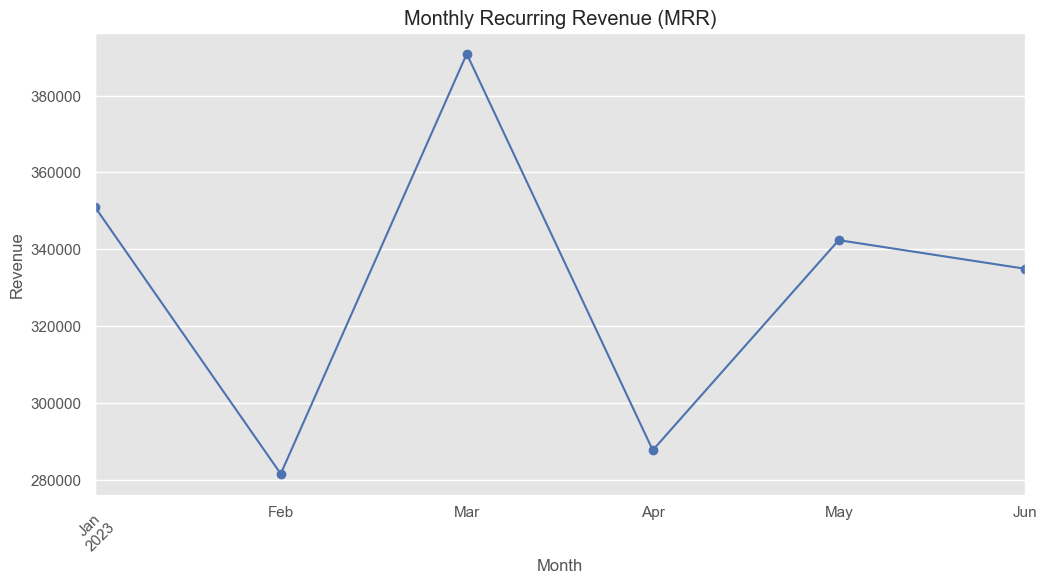

In [539]:
# Добавляем колонку с месячным доходом от подписки
# premium_purchases_df['revenue'] = premium_purchases_df['purchase_month'].map(price_by_type)

# Группируем по месяцам покупки и суммируем выручку
monthly_revenue = premium_purchases_df.groupby('purchase_month')['revenue'].sum()

# Строим график выручки по месяцам
plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', color='b', marker='o')
plt.title('Monthly Recurring Revenue (MRR)')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

##### Динамика подписок и отписок

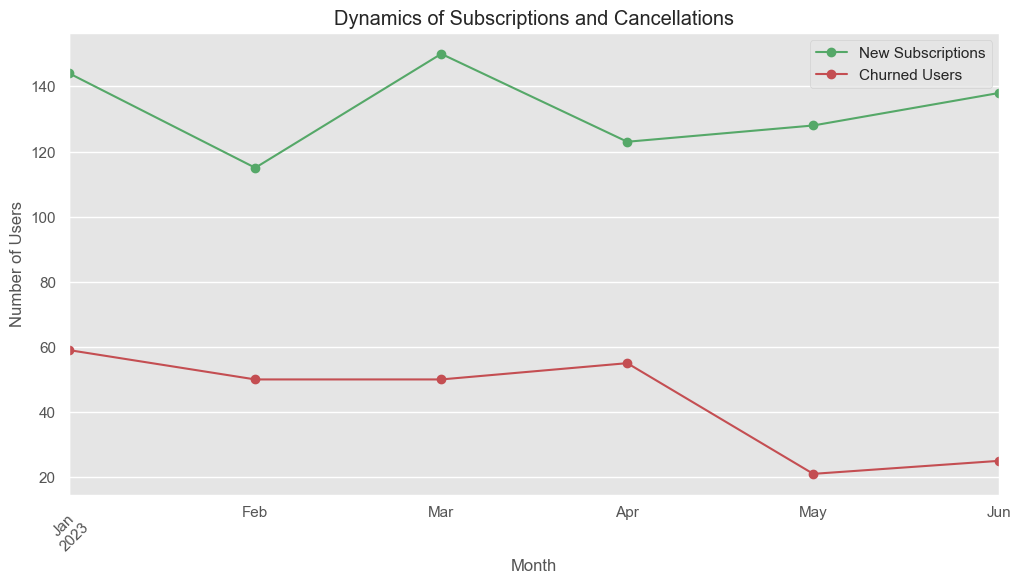

In [540]:
# Подписки
subscriptions = premium_purchases_df.groupby('purchase_month')['user_id'].nunique()

# Отписки (пользователи, у которых дата окончания подписки уже прошла)
churn = premium_purchases_df[premium_purchases_df['subscription_end'] <= pd.Timestamp('2023-10-30')].groupby('purchase_month')['user_id'].nunique()

# Строим график подписок и отписок
plt.figure(figsize=(12, 6))
subscriptions.plot(kind='line', color='g', marker='o', label='New Subscriptions')
churn.plot(kind='line', color='r', marker='o', label='Churned Users')
plt.title('Dynamics of Subscriptions and Cancellations')
plt.xlabel('Month')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

#####  Средний чек (ARPU) по месяцам

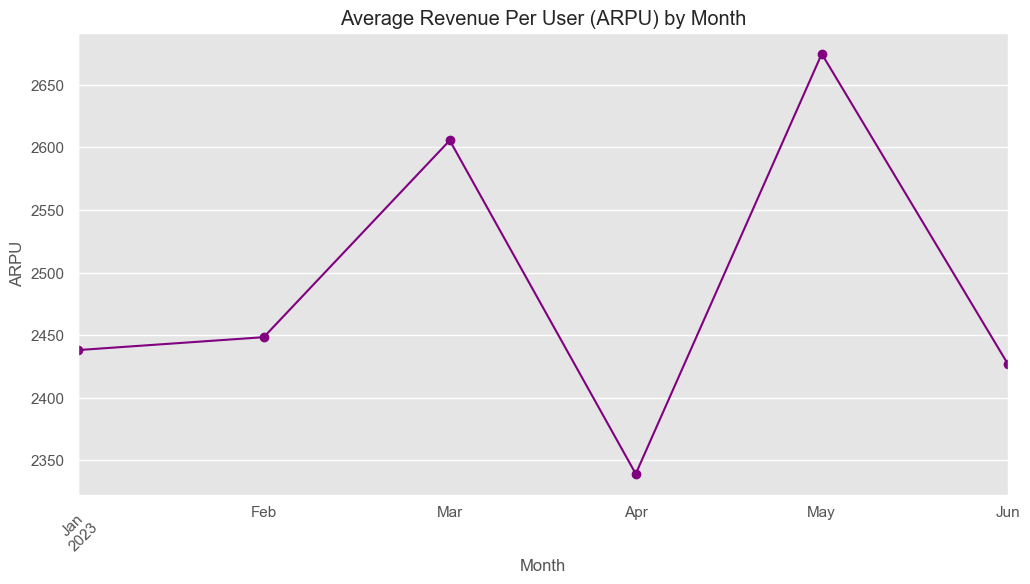

In [541]:
# Рассчитываем ARPU по месяцам
monthly_arpu = monthly_revenue / subscriptions

# Строим график ARPU по месяцам
plt.figure(figsize=(12, 6))
monthly_arpu.plot(kind='line', color='purple', marker='o')
plt.title('Average Revenue Per User (ARPU) by Month')
plt.xlabel('Month')
plt.ylabel('ARPU')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Какую метрику выбрать для отслеживания числа заходов пользователей в Telegram за месяц?

Метрикy MAU (Monthly Active Users) – количество уникальных пользователей, зашедших в Telegram хотя бы раз за месяц - использовать **НЕ** целесообразно, так как телеграм - это мессенджер, и если пользователь заходит раз в месяц - это не показатель

=> предлагаю использовать DAU и WAU, а также среднее число заходов на пользователя

То есть:

• DAU (Daily Active Users) – активность по дням \
• WAU (Weekly Active Users) – активность по неделям \
• Среднее число заходов на пользователя

<!-- Как это измерять? \
• Логируем каждое открытие приложения \
• Учитываем пользователей, отправивших хотя бы одно сообщение (чтобы отсечь “случайные” открытия) \
• Строим тренды и сезонность -->


##### DAU – Daily Active Users

array([[<Axes: title={'center': 'user_id'}>]], dtype=object)

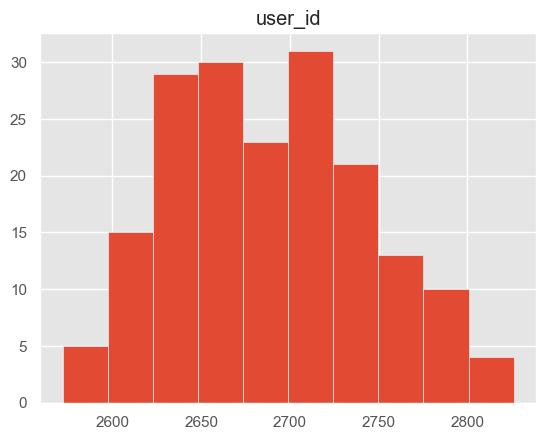

In [542]:
dau_df = logs_df.copy()
total_users = dau_df['user_id'].nunique()
dau_df = dau_df.groupby('day').agg({'user_id':'nunique'})
dau_df.hist()

Среднее число посетителей в день: 2689.0773480662983


<Axes: xlabel='day'>

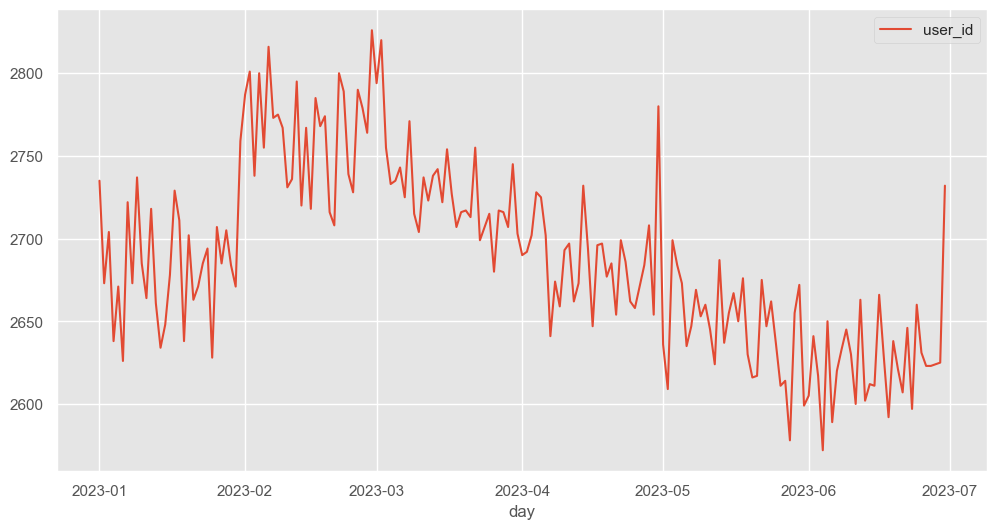

In [543]:
print(f"Среднее число посетителей в день: {dau_df.user_id.mean()}")
dau_df.sort_index().plot(figsize=(12,6))

##### WAU – Weekly Active Users

/var/folders/4r/l6jgz7s11rs2s5hc02k5l7z00000gn/T/ipykernel_1055/1184984312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_dialog_logs['week'] = open_dialog_logs['timestamp'].dt.to_period('W').dt.start_time


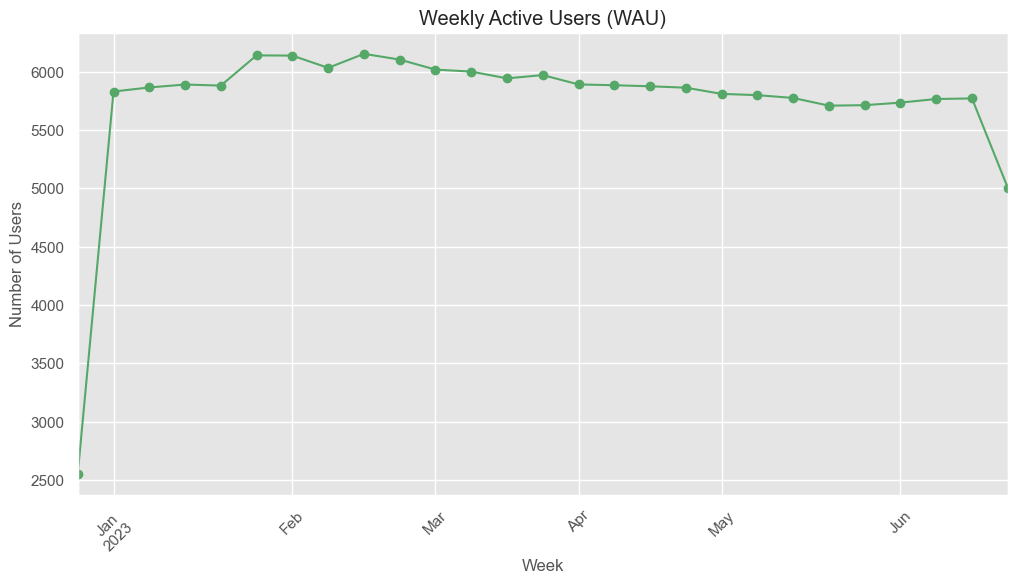

In [544]:
# Создаем столбец с неделей для группировки
open_dialog_logs['week'] = open_dialog_logs['timestamp'].dt.to_period('W').dt.start_time

# Группируем по неделям и считаем уникальных пользователей
wau = open_dialog_logs.groupby('week')['user_id'].nunique()

# Строим график WAU
plt.figure(figsize=(12, 6))
wau.plot(kind='line', color='g', marker='o')
plt.title('Weekly Active Users (WAU)')
plt.xlabel('Week')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### Среднее число сессий на пользователя

<Figure size 1200x600 with 0 Axes>

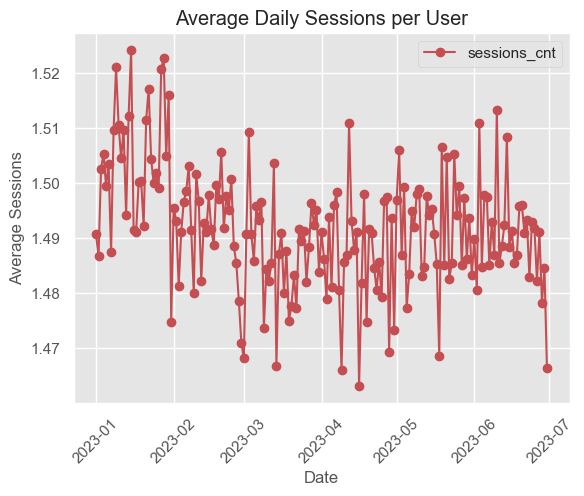

In [545]:
# Группируем по дате и пользователю, считаем количество событий
daily_sessions = logs_df.groupby(['day', 'user_id'], as_index=False) \
                                .agg({'session_id':'nunique'}) \
                                .rename({'session_id':'sessions_cnt'}, axis=1)

# Рассчитываем среднее количество событий на пользователя за день
avg_daily_sessions_per_user = daily_sessions.groupby('day').agg({'sessions_cnt':'mean'})

# Строим график
plt.figure(figsize=(12, 6))
avg_daily_sessions_per_user.plot(kind='line', color='r', marker='o')
plt.title('Average Daily Sessions per User')
plt.xlabel('Date')
plt.ylabel('Average Sessions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

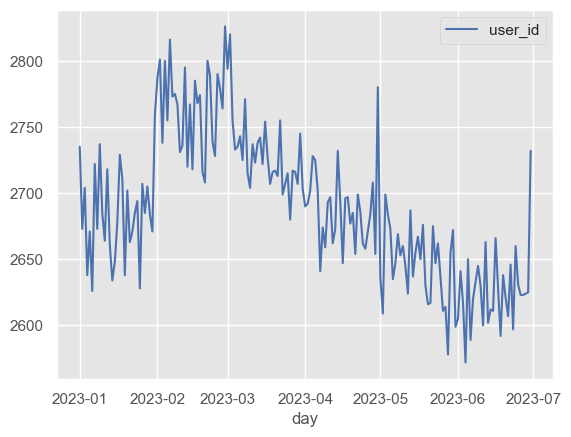

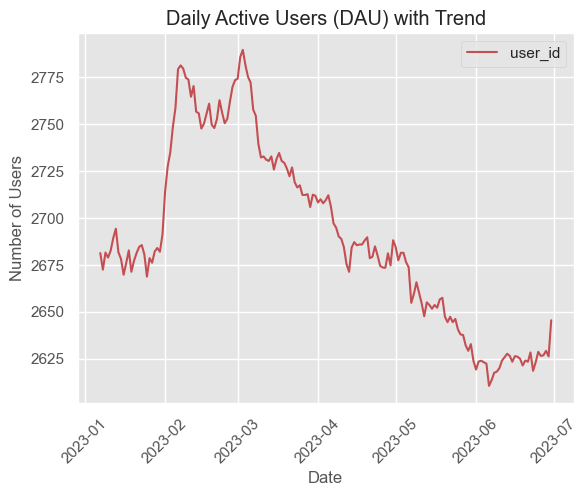

In [548]:
# Рассчитываем скользящее среднее (например, для DAU)
dau_smoothed = dau_df.rolling(window=7).mean()

# Строим график с трендом
plt.figure(figsize=(12, 6))
dau_df.plot(kind='line', color='b', label='DAU')
dau_smoothed.plot(kind='line', color='r', label='7-day Moving Average')
plt.title('Daily Active Users (DAU) with Trend')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Дополнительные гипотезы для проверки:

1. `Поведение до и после подписки`

Можно взять пользователей, купивших подписку, и посмотреть, как меняется их активность: отправка сообщений, использование функций.


2. `Анализ оттока (churn)`

Если пользователь не продлевает подписку — сколько времени он был активен до этого? Можно ли предсказать churn?


3. `Анализ “первой подписки”`

Что объединяет пользователей, оформивших первую подписку? Возможно, есть паттерны в активности до покупки.

##### Поведение до и после подписки

In [671]:
from datetime import timedelta

# Все покупки подписки
premium_df = pd.concat([premium_purchases_df, premium_purchases_hist_df], ignore_index=True)
premium_df['timestamp'] = pd.to_datetime(premium_df['timestamp'])

# Лог-файл
# logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp'])

# Берём только события buy_premium
first_subs = premium_df.groupby('user_id')['timestamp'].min().reset_index()
first_subs.columns = ['user_id', 'first_sub_time']

# Добавляем в логи дату подписки
logs_with_subs = logs_df.merge(first_subs, on='user_id', how='inner')
logs_with_subs['period'] = logs_with_subs.apply(
    lambda row: 'before' if row['timestamp'] < row['first_sub_time'] else 'after', axis=1
)

# Фильтруем на ±30 дней от подписки
logs_with_subs = logs_with_subs[
    (logs_with_subs['timestamp'] >= logs_with_subs['first_sub_time'] - timedelta(days=30)) &
    (logs_with_subs['timestamp'] <= logs_with_subs['first_sub_time'] + timedelta(days=30))
]

# Группируем по юзеру и периоду
user_activity = logs_with_subs.groupby(['user_id', 'period'])['event_type'].count().unstack().fillna(0)
user_activity['delta'] = user_activity['after'] - user_activity['before']

# Среднее по всем пользователям
print(user_activity[['before', 'after', 'delta']].mean())

period
before     588.056628
after     1659.754183
delta     1071.697555
dtype: float64


###### Проверка полученных результатов на значимые различия (t-test)

In [676]:
# Разделим данные на две группы (до и после)
before_activity = user_activity['before']
after_activity = user_activity['after']

# Проведем t-тест
t_stat, p_value = stats.ttest_rel(before_activity, after_activity)

# Выведем результаты t-теста
print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_value}")

# Интерпретация p-значения
if p_value < 0.05:
    print("Есть статистически значимая разница в активности до и после подписки (p < 0.05).")
else:
    print("Нет статистически значимой разницы в активности до и после подписки (p >= 0.05).")

t-статистика: -23.467637291512293
p-значение: 1.8781349435377795e-92
Есть статистически значимая разница в активности до и после подписки (p < 0.05).


##### Анализ оттока (churn)

In [ ]:
# 1.Объединяем пользователей с подпиской
# 2.Вычисляем последний день активности
# 3.Смотрим, кто не купил снова после окончания подписки

In [691]:
def calculate_subscription_periods(premium_df):
    months = {"3_months": 3, "6_months": 6, "12_months": 12}
    premium_df = premium_df.sort_values(by=["user_id", "timestamp"])

    result = []
    current_ends = {}

    for row in premium_df.itertuples():
        user_id = row.user_id
        sub_months = months[row.subscription_type]
        purchase_time = row.timestamp

        prev_end = current_ends.get(user_id, purchase_time)
        new_start = max(purchase_time, prev_end)
        new_end = new_start + DateOffset(months=sub_months)
        current_ends[user_id] = new_end

        result.append(new_end)

    premium_df["subscription_end"] = result
    return premium_df

# Считаем конец подписки
premium_full = calculate_subscription_periods(premium_purchases_df)
premium_full = premium_full.sort_values(by=['user_id', 'timestamp'])

# Считаем дату последнего события
last_active = logs_df.groupby('user_id')['timestamp'].max().reset_index()
last_active.columns = ['user_id', 'last_seen']

# Берем только последние подписки
last_sub = premium_full.groupby('user_id').last().reset_index()
last_sub = last_sub[['user_id', 'subscription_end']]

# Соединяем
churn_df = last_sub.merge(last_active, on='user_id', how='left')
churn_df['days_after_end'] = (churn_df['last_seen'] - churn_df['subscription_end']).dt.days

# Метка churn (если пользователь НЕ активен в течение 30+ дней после окончания подписки)
churn_df['churned'] = churn_df['days_after_end'] > 30

print(churn_df['churned'].value_counts(normalize=True))
print()

# ушло ~4.5% пользователей:
churn_percentage = churn_df['churned'].value_counts(normalize=True) * 100
print(churn_percentage.round(2))

False    0.954887
True     0.045113
Name: churned, dtype: float64

False    95.49
True      4.51
Name: churned, dtype: float64


#### Можно также построить модель для предсказания оттока (churn) с использованием логистической регрессии, на основе активности пользователя до окончания подписки

In [ ]:
!!! доделать

##### Анализ “первой подписки”
Что объединяет пользователей, оформивших первую подписку? Возможно, есть паттерны в активности до покупки.

In [ ]:
# 1.Берём только события до подписки.
# 2.Строим метрики активности: количество сессий, уникальных дней, событий.
# 3.Сравниваем с пользователями без подписки.

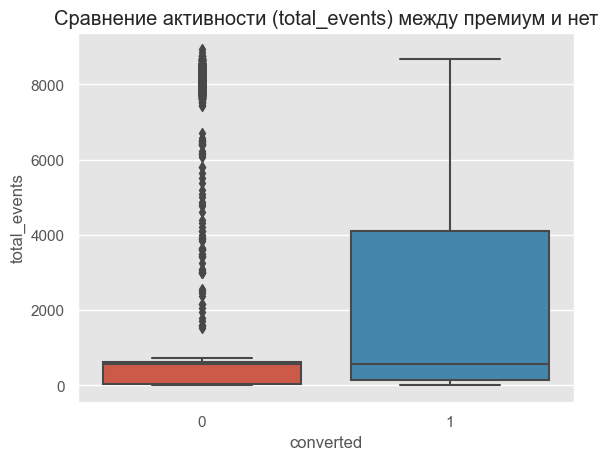

In [709]:
# Пользователи с подпиской
users_with_sub = first_subs.copy()
users_with_sub.columns = ['user_id', 'sub_time']

# Логи до подписки
logs_before = logs_df.merge(users_with_sub, on='user_id', how='inner')
logs_before = logs_before[logs_before['timestamp'] < logs_before['sub_time']]

# Метрики активности до подписки
before_metrics = logs_before.groupby('user_id').agg({
    'event_type': 'count',
    'timestamp': lambda x: x.dt.date.nunique(),
    'session_id': pd.Series.nunique
}).reset_index()

before_metrics.columns = ['user_id', 'total_events', 'active_days', 'unique_sessions']

# Присоединяем метки
before_metrics['converted'] = 1

# Пользователи без подписки
non_premium_users = user_data_df[~user_data_df['user_id'].isin(users_with_sub['user_id'])]
non_premium_logs = logs_df[logs_df['user_id'].isin(non_premium_users['user_id'])]

# Такие же метрики
non_sub_metrics = non_premium_logs.groupby('user_id').agg({
    'event_type': 'count',
    'timestamp': lambda x: x.dt.date.nunique(),
    'session_id': pd.Series.nunique
}).reset_index()

non_sub_metrics.columns = ['user_id', 'total_events', 'active_days', 'unique_sessions']
non_sub_metrics['converted'] = 0

# Объединяем
df_merged = pd.concat([before_metrics, non_sub_metrics], ignore_index=True)

# Анализ различий
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_merged, x='converted', y='total_events')
plt.title('Сравнение активности (total_events) между премиум и нет')
plt.show()